In [5]:
from imutils import contours
from skimage import measure
import numpy as np
import imutils
import cv2
import pandas as pd
import glob
import swifter

import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

In [6]:
df = pd.read_csv('exceptions.csv')

In [7]:
df_clean = df[df.raises_exception] 

In [8]:
df_clean

,path,raises_exception
0,dataset/ocular/0/2342_left.jpg,True
1,dataset/ocular/0/3407_right.jpg,True
2,dataset/ocular/0/2343_left.jpg,True
3,dataset/ocular/0/3294_right.jpg,True
4,dataset/ocular/0/940_right.jpg,True
...,...,...
3418,dataset/ocular/1/1386_left.jpg,True
3419,dataset/ocular/1/1964_left.jpg,True
3420,dataset/ocular/1/1265_right.jpg,True
3422,dataset/ocular/1/1503_right.jpg,True


In [43]:
def get_folder(path):
    return path.split('/')[2]

def get_file(path):
    return path.split('/')[-1]

In [10]:
df_clean['folder'] = df_clean.path.swifter.progress_bar(True).apply(get_folder)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [44]:
df_clean['file'] = df_clean.path.swifter.progress_bar(True).apply(get_file)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [45]:
df_clean

,path,raises_exception,folder,file
0,dataset/ocular/0/2342_left.jpg,True,0,2342_left.jpg
1,dataset/ocular/0/3407_right.jpg,True,0,3407_right.jpg
2,dataset/ocular/0/2343_left.jpg,True,0,2343_left.jpg
3,dataset/ocular/0/3294_right.jpg,True,0,3294_right.jpg
4,dataset/ocular/0/940_right.jpg,True,0,940_right.jpg
...,...,...,...,...
3418,dataset/ocular/1/1386_left.jpg,True,1,1386_left.jpg
3419,dataset/ocular/1/1964_left.jpg,True,1,1964_left.jpg
3420,dataset/ocular/1/1265_right.jpg,True,1,1265_right.jpg
3422,dataset/ocular/1/1503_right.jpg,True,1,1503_right.jpg


In [52]:
def get_disk(row):
  try:
    image = row.path
    folder = row.folder
    file = row.file
    image = cv2.imread(image)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.bilateralFilter(gray,9,75,75)
    median=cv2.medianBlur(blur, 5)

    # threshold the image to reveal light regions in the
    # blurred image
    thresh = cv2.threshold(median, 155, 255, cv2.THRESH_BINARY)[1]
    # perform a series of erosions and dilations to remove
    # any small blobs of noise from the thresholded image
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=4)

    # perform a connected component analysis on the thresholded
    # image, then initialize a mask to store only the "large"
    # components
    labels = measure.label(thresh, connectivity=2, background=0)
    mask = np.zeros(thresh.shape, dtype="uint8")

    # loop over the unique components
    for label in np.unique(labels):
      # if this is the background label, ignore it
      if label == 0:
        continue

      # otherwise, construct the label mask and count the
      # number of pixels 
      labelMask = np.zeros(thresh.shape, dtype="uint8")
      labelMask[labels == label] = 255
      numPixels = cv2.countNonZero(labelMask)

      # if the number of pixels in the component is sufficiently
      # large, then add it to our mask of "large blobs"
      if numPixels >500:
        mask = cv2.add(mask, labelMask)

    # find the contours in the mask, then sort them from left to
    # right
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
      cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = contours.sort_contours(cnts)[0]
    # print (cnts)
    # loop over the contours
    for (i, c) in enumerate(cnts):
        ellipse = cv2.fitEllipse(c)
        (x, y, w, h) = cv2.boundingRect(c)
        break
      # draw the bright spot on the image

    padding = 100
    image = image[y-padding:y+h+padding, x-padding:x+w+padding]
    color_coverted = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pil_image=Image.fromarray(color_coverted)
    pil_image.save("disk_dataset/"+str(folder)+"/"+file)
#     return image
  except:
    pass

# No clue what is happening here

In [53]:
df_clean.swifter.progress_bar(True).apply(get_disk, axis=1)

0       None
1       None
2       None
3       None
4       None
        ... 
3418    None
3419    None
3420    None
3422    None
3423    None
Length: 3043, dtype: object

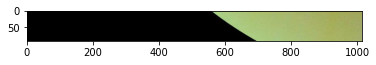

In [41]:
plt.imshow(get_disk("dataset/ocular/0/2343_left.jpg"))

In [ ]:
df